In [132]:
import pandas as pd
import plotly.express as px
import shapely.wkt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes

In [106]:
df = pd.read_csv('../Data/bikes_station_location.csv')
df.loc[0]

Station #                                       1000
Station Name                Liberty Ave & Stanwix St
NumRacks                                          16
Latitude                                     40.4413
Longitude                                   -80.0047
coordinates     POINT (-80.00467900000001 40.441326)
Name: 0, dtype: object

In [107]:
df = df.rename(columns={"Station Name": "Station_Name"})

for row in range(len(df)):
    df.at[row,"coordinates"] = shapely.wkt.loads(df.loc[row]["coordinates"])

### Location of Bike Stations
Size of each circle for the bike station location represents the number of bike racks at that station

In [108]:
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Station_Name", size="NumRacks",
                  color_continuous_scale=px.colors.diverging.Picnic, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

# Annotating

In [109]:
#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
cenTract.head(1)

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,tractce10_,cnt_tractc,sum_lowmod,sum_lowm_1,lowmodperc,lowmodpe_1,cdbg2018,Shape__Are,Shape__Len,geometry
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,040500,2,2775,2985,92.964824,92.96,Yes,5.079492e+06,10442.03645,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."


In [110]:
#for every point (bike station), check if if it exists in that polygon (census tract)
df.at[80,"coordinates"] = Point(-79.92787,40.4677154)
for row in range(len(df)):
    for tract in range(len(cenTract)):
        if df.loc[row]["coordinates"].within(cenTract.loc[tract]["geometry"]):
            df.at[row,"tractce10"] = cenTract.loc[tract]["tractce10"] 

### Plot by census tract

In [111]:
df['tractce10'] = df.tractce10.astype(str)

fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="tractce10", size="NumRacks",
                color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

In [112]:
df.to_csv('../Data/stations_census_tracts.csv', index=False)

### Counting Number of Stations per Tract

In [124]:
data = []
count = 0

for row in range(len(cenTract)):
    data.append([cenTract.loc[row]['tractce10'], count])
    
tracts_df = pd.DataFrame(data, columns = ['tractce10', 'count'])

for row in range(len(cenTract)):
    count = 0
    cen = cenTract.loc[row]['tractce10']
#     print("Census Tract: ", cen)
    for row2 in range(len(df)):
        dfcen = df.loc[row2]['tractce10']
#         print("Current Row Tract: ", dfcen)
        if cen == dfcen:
#             print("adding")
            count += 1
#             print("count is now: ", count)
#     print("End of dataframe - adding total")
#     print("total is ", count)
#     print(tracts_df.loc[tracts_df['tractce10'] == cen])
    idx = tracts_df.loc[tracts_df['tractce10'] == cen].index
    tracts_df.at[idx,'count'] = count
#     print("added")
#     print(tracts_df.loc[tracts_df['tractce10'] == cen])


### Mapping count of stations per census tract

<ipython-input-134-926f9b5215fb>:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




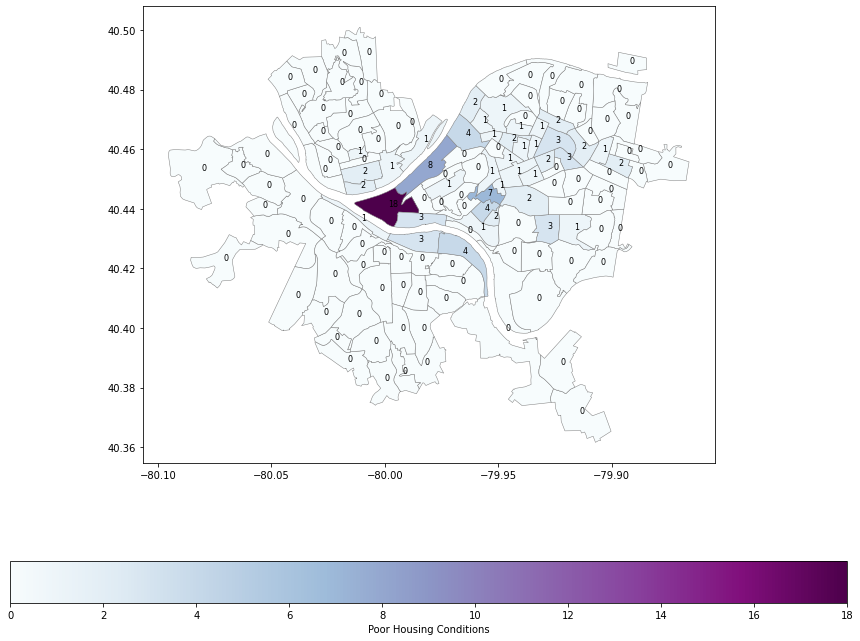

In [134]:
final_df = cenTract.merge(tracts_df, on='tractce10')

#find the centroids of each neighborhood for labeling
final_df["center"] = final_df["geometry"].centroid
map_points = final_df.copy()
map_points.set_geometry("center", inplace = True)
#plot the neighborhood ids on the map
final_df.plot(column="count", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "horizontal"})
    
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["count"]):
    texts.append(plt.text(x, y, label, fontsize = 8))